# Chess Pieces (駒）
Once the full systems have been computed, we can then analyze the ligands in the context of the protein environment. 

In [1]:
from os.path import join
from futile.Utils import ensure_dir
outdir = "serialized"
cache = "temp"
ensure_dir(cache)

False

Read in the structures.

In [2]:
from pickle import load
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)

In [4]:
from multiprocessing import Pool
from pickle import load, dump
import time
from BigDFT import BioQM
from BigDFT.Systems import System
from os.path import join
from os.path import exists

# Read in the data
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)

# Fill in this routine with all of the loading you want to do
def read(geom):
    cname = join(cache, geom + ".pickle")

    try:
        with open(cname, "rb") as ifile:
            sys = load(ifile)
    except:
        fname = join(outdir, geom + "-XTB-1.1.tar.bz2")
        options = dict(sequence_from_fragments=True, disable_warnings=True)
        sys = BioQM.load(fname, options=options)
        energies = sys.interactions
        purities = sys.purities
        bond_orders = sys.bond_orders
        
        for attr in ["_atomic_purities", "_atomic_BO", "_atomic_interactions"]:
            if hasattr(sys, attr):
                delattr(sys, attr)
        
        with open(cname, "wb") as ofile:
            dump(sys, ofile)
        
    return geom, sys

# Set the number of threads yourself
numthreads = 3
p = Pool(numthreads)

# Actual call 
geoms = data["Crystal ID"][:]
systems = {}
start = time.time()
# res = p.map(read, geoms)
res = []
for g in geoms:
    res.append(read(g))
end = time.time()
print(end - start)

# Unpack results into this dictionary
for val in res:
    g = val[0]
    systems[g] = val[1]

30.826509952545166


The first thing we will do is look at the purity of the ligand fragments. What we want to verify is that being introduced into the environment has not modified any ligand enough to change how we want to fragment.

In [5]:
covalent_lookup = {}
for g, c in zip(data["Crystal ID"], data["Site"]):
    covalent_lookup[g] = "cov" in c

In [6]:
non_purities = {}
cov_purities = {}
for g in geoms:
    for fragid, pv in systems[g].purities.items():
        pv = abs(pv)
        if "LIG" not in fragid and "FRA" not in fragid:
            continue
        if covalent_lookup[g]:
            cov_purities[(g,fragid)] = pv
        else:
            non_purities[(g,fragid)] = pv

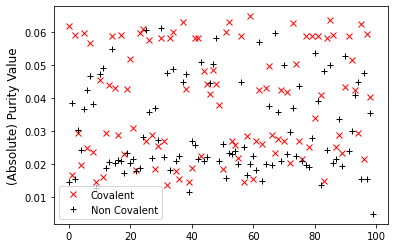

In [40]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,1)
axs.plot(list(cov_purities.values()), 'rx', label="Covalent")
axs.plot(list(non_purities.values()), 'k+', label="Non Covalent")
axs.set_ylabel("(Absolute) Purity Value", fontsize=12)
axs.legend()

We do find that some fragments have moved above the 0.5 threshold we aim for. Most of these are covalent ones, which is unsurprising given the bonding occuring. However, we also find that there are noncovalent fragments being modified by their interaction with the protein.

## Interaction Strength
Next we examine the interaction strength of the various fragments with the protein.

In [9]:
non_strengths = {}
cov_strengths = {}
strengths = {}
for g in geoms:
    for fid1, f1 in systems[g].interactions.items():
        if "FRA" not in fid1 and "LIG" not in fid1:
            continue
        temp = 0.0
        for fid2, f2 in f1.items():
            if "FRA" in fid2 or "LIG" in fid2:
                continue
            temp += f2
        if covalent_lookup[g]:
            cov_strengths[(g,fid1)] = temp
        else:
            non_strengths[(g,fid1)] = temp
        strengths[(g,fid1)] = temp

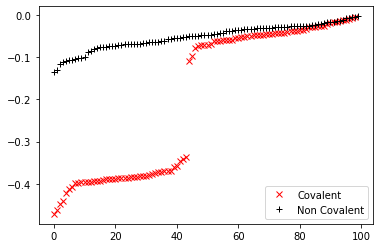

In [10]:
fig, axs = plt.subplots(1,1)
axs.plot(sorted(list(cov_strengths.values())), 'rx', label = "Covalent")
axs.plot(sorted(list(non_strengths.values())), 'k+', label="Non Covalent")
axs.legend()

We want to extract these fragments in an easy to understand way. To do that, let's generate the SMILES representation of each one.

In [11]:
from os import system
from BigDFT.IO import write_pdb

smiles = {}
for g, f1 in strengths:
    name = str(g) + "-" + f1
    oname1 = join(cache, name+"-strongest.pdb")
    oname2 = join(cache, name+"-strongest.smiles")
    
    if not exists(oname1) and not exists(oname2):
        sys = System()
        sys[f1] = systems[g][f1]

        with open(oname1, "w") as ofile:
            write_pdb(sys, ofile)

        system("obabel -ipdb " + oname1 + " -ocan > " + oname2)
    
    with open(oname2) as ifile:
        smiles[(g, f1)] = next(ifile).split()[0]

Now let's take a look at the outlier.

In [12]:
cov_out = {}
non_out = {}

for g in geoms:
    for fid, f1 in systems[g].interactions.items():
        if "FRA" not in fid and "LIG" not in fid:
            continue
        key = smiles[(g,fid)]
        val = strengths[(g,fid)]

        if val < - 0.4:
            if key in cov_out:
                cov_out[key] = min(cov_out[key], val)
            else:
                cov_out[key] = val
        elif val < - 0.1 and val > -0.2:
            if key in non_out:
                non_out[key] = min(non_out[key], val)
            else:
                non_out[key] = val

Covalent motifs

In [34]:
def draw(smi):
    from rdkit.Chem import Draw, MolFromSmiles
    from rdkit.Chem.Draw import IPythonConsole
    mols = [MolFromSmiles(x) for x in smi]
    leg = [str(x) for x in smi.values()]
    return Draw.MolsToGridImage(mols, legends=leg)

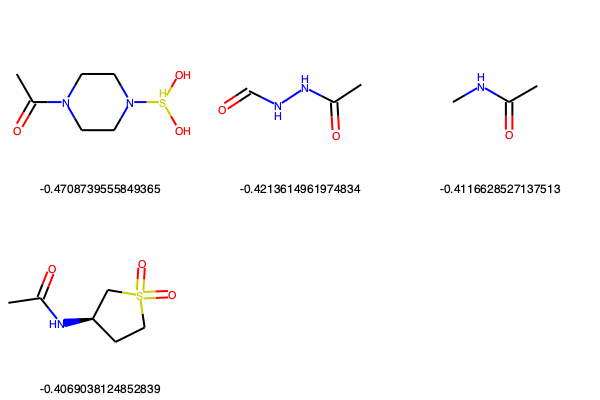

In [35]:
draw(cov_out)

Non-covalent motifs

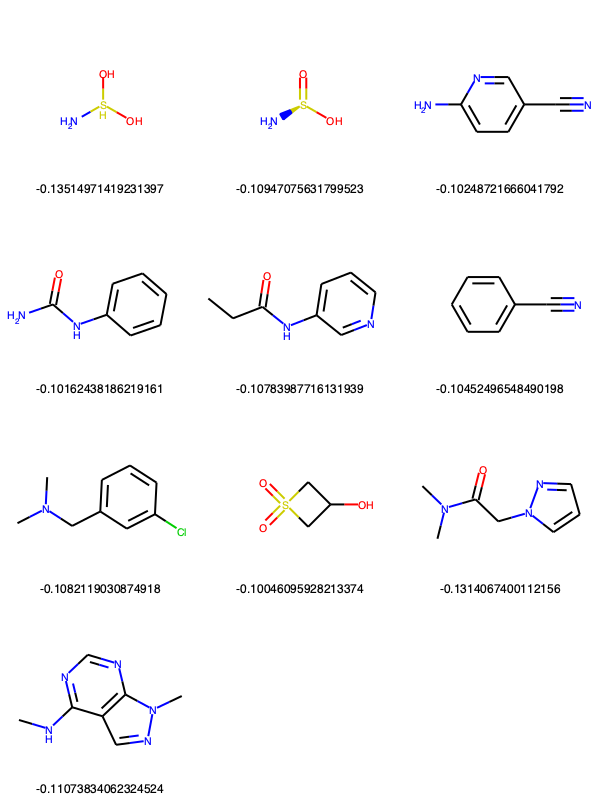

In [38]:
draw(non_out)